<a href="https://colab.research.google.com/github/somkiatth/git/blob/master/ku-hotel_booking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. ลง PySpark

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 44 kB/s 
     |████████████████████████████████| 199 kB 69.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=5757b345bca3a9d52f677463cbdd9a2a5bb5b9b4d91199cf538a5bc603d35aef
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName('hotel_booking').getOrCreate()

# 2. เปิดไฟล์สร้างเป็นตาราง

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/Datasets/hotel_bookings.csv',
                     header=True, inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [ ]:
df.count()

119390

In [ ]:
len(df.columns)

32

# 3.	แสดงข้อมูล 5 แถวแรกของตารางและคอลัมน์ชื่อ arrival_date_year, arrival_date_month และ arrival_date_day_of_month

In [ ]:
df.select('arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month').show(5)

+-----------------+------------------+-------------------------+
|arrival_date_year|arrival_date_month|arrival_date_day_of_month|
+-----------------+------------------+-------------------------+
|             2015|              July|                        1|
|             2015|              July|                        1|
|             2015|              July|                        1|
|             2015|              July|                        1|
|             2015|              July|                        1|
+-----------------+------------------+-------------------------+
only showing top 5 rows



# 4.	ลูกค้าที่จองล่วงหน้า (lead_time) มากกว่า 365 วันมีกี่ราย

In [ ]:
from pyspark.sql import functions as F

In [ ]:
df.where('lead_time > 365').count()

3148

# 5.	ลูกค้าที่จองห้องต่อเนื่องทั้งวันธรรมดา (stays_in_week_nights) และวันสุดสัปดาห์ (stays_in_weekend_nights) มีกี่ราย

In [ ]:
df.where('stays_in_week_nights > 0 AND stays_in_weekend_nights > 0').count()

60462

# 6. คอลัมน์ children เป็นประเภท string เพราะมีคำว่า “NA” อยู่ ให้เปลี่ยนคำว่า NA ให้เป็น 0 

In [ ]:
df.drop_duplicates(['children']).show()

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+---------------+------+---------------------------+-------------------------+------------------+-----------------------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|  customer_type|   adr|required_car_parking_space

In [ ]:
df.where('children = "NA"').show()

+----------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+---------------+----+---------------------------+-------------------------+------------------+-----------------------+
|     hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|  customer_type| adr|required_car_parking_spaces|total_

In [ ]:
df = df.withColumn('children', F.when(df.children == 'NA', 0).otherwise(df.children) )

# 7.	หาค่าเฉลี่ยของจำนวนเด็ก (children) ของการจองแต่ละครั้ง

In [ ]:
df.agg({'children':'mean'}).show()

+-------------------+
|      avg(children)|
+-------------------+
|0.10388642264846303|
+-------------------+



In [ ]:
df.groupby('children').count().show()

+--------+------+
|children| count|
+--------+------+
|       3|    76|
|       0|110800|
|       1|  4861|
|      10|     1|
|       2|  3652|
+--------+------+



# 8.	ผู้จองโรงแรมมาจากกี่ประเทศ (country) (นับจำนวนประเทศที่ไม่ซ้ำ)

In [ ]:
df.select( F.count_distinct('country') ).show()

+-----------------------+
|count(DISTINCT country)|
+-----------------------+
|                    178|
+-----------------------+



# 9.	นับจำนวนผู้จองแยกตามโรงแรม (hotel)

In [ ]:
df.groupby('hotel').count().show()

+------------+-----+
|       hotel|count|
+------------+-----+
|  City Hotel|79330|
|Resort Hotel|40060|
+------------+-----+



# 10.	นับจำนวนผู้จองแยกตามประเทศ (country) เรียงตามลำดับจากมากไปน้อย แสดงแค่ 5 ประเทศแรก

In [ ]:
df.groupby('country').count().sort('count', ascending=False).show(5)

+-------+-----+
|country|count|
+-------+-----+
|    PRT|48590|
|    GBR|12129|
|    FRA|10415|
|    ESP| 8568|
|    DEU| 7287|
+-------+-----+
only showing top 5 rows



# 11.	หาค่าเฉลี่ยของจำนวนวันที่จองล่วงหน้า (lead_time) แยกตามประเภทลูกค้า (customer_type)

In [ ]:
df.groupby('customer_type').agg({'lead_time':'mean'}).show()

+---------------+------------------+
|  customer_type|    avg(lead_time)|
+---------------+------------------+
|      Transient| 93.29551515963085|
|Transient-Party|137.03705620124185|
|          Group| 55.05719237435009|
|       Contract| 142.9698233562316|
+---------------+------------------+



# 12.	สร้างคอลัมน์ใหม่ชื่อ arrival_date ที่เก็บ timestamp ของวันที่ผู้เข้าพักมาถึงโรงแรม คอลัมน์นี้สร้างได้ด้วยการนำคอลัมน์ arrival_date_year, arrival_date_month และ arrival_date_day_of_month มาต่อกันคั่นด้วยเครื่องหมาย “-“ แล้วแปลงเป็น timestamp

In [ ]:
df.select( F.concat(df.arrival_date_year.astype('string'),
                    F.lit("-"),
                    df.arrival_date_month,
                    F.lit("-"),
                    df.arrival_date_day_of_month.astype('string') ) ).show()

+--------------------------------------------------------------------------------------------------------------+
|concat(CAST(arrival_date_year AS STRING), -, arrival_date_month, -, CAST(arrival_date_day_of_month AS STRING))|
+--------------------------------------------------------------------------------------------------------------+
|                                                                                                   2015-July-1|
|                                                                                                   2015-July-1|
|                                                                                                   2015-July-1|
|                                                                                                   2015-July-1|
|                                                                                                   2015-July-1|
|                                                                                               

In [ ]:
df = df.withColumn('arrival_date', F.to_timestamp(F.concat(df.arrival_date_year.astype('string'),
                    F.lit("-"),
                    df.arrival_date_month,
                    F.lit("-"),
                    df.arrival_date_day_of_month.astype('string') ), format='yyyy-MMMM-d' ) )

In [ ]:
df.select('arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date').sample(0.0001).show()

+-----------------+------------------+-------------------------+-------------------+
|arrival_date_year|arrival_date_month|arrival_date_day_of_month|       arrival_date|
+-----------------+------------------+-------------------------+-------------------+
|             2015|            August|                        8|2015-08-08 00:00:00|
|             2017|              July|                       24|2017-07-24 00:00:00|
|             2015|              July|                       31|2015-07-31 00:00:00|
|             2015|           October|                       24|2015-10-24 00:00:00|
|             2016|          February|                       21|2016-02-21 00:00:00|
|             2015|              July|                       25|2015-07-25 00:00:00|
|             2015|            August|                        5|2015-08-05 00:00:00|
|             2015|           October|                        4|2015-10-04 00:00:00|
|             2015|          December|                       29|2

# 13.	สรุปจำนวนผู้เข้าพักที่มาถึงโรงแรมในแต่ละวัน ให้ใช้คอลัมน์ arrival_date ในการระบุวันมาถึง ไม่นับลูกค้าที่ไม่มา (is_canceled เป็น 1) เรียงลำดับตามวันที่เข้าพัก

In [ ]:
window = F.window('arrival_date', '1 day')

In [ ]:
df.filter('is_canceled = 0').groupby(window).count().sort('window').show(truncate=False)

+------------------------------------------+-----+
|window                                    |count|
+------------------------------------------+-----+
|{2015-07-01 00:00:00, 2015-07-02 00:00:00}|103  |
|{2015-07-02 00:00:00, 2015-07-03 00:00:00}|36   |
|{2015-07-03 00:00:00, 2015-07-04 00:00:00}|37   |
|{2015-07-04 00:00:00, 2015-07-05 00:00:00}|45   |
|{2015-07-05 00:00:00, 2015-07-06 00:00:00}|37   |
|{2015-07-06 00:00:00, 2015-07-07 00:00:00}|41   |
|{2015-07-07 00:00:00, 2015-07-08 00:00:00}|29   |
|{2015-07-08 00:00:00, 2015-07-09 00:00:00}|45   |
|{2015-07-09 00:00:00, 2015-07-10 00:00:00}|29   |
|{2015-07-10 00:00:00, 2015-07-11 00:00:00}|42   |
|{2015-07-11 00:00:00, 2015-07-12 00:00:00}|61   |
|{2015-07-12 00:00:00, 2015-07-13 00:00:00}|37   |
|{2015-07-13 00:00:00, 2015-07-14 00:00:00}|39   |
|{2015-07-14 00:00:00, 2015-07-15 00:00:00}|24   |
|{2015-07-15 00:00:00, 2015-07-16 00:00:00}|54   |
|{2015-07-16 00:00:00, 2015-07-17 00:00:00}|41   |
|{2015-07-17 00:00:00, 2015-07-

# 14.	แสดงจำนวนการจองรายเดือนแยกตามโรงแรม (hotel) ให้ใช้คอลัมน์ arrival_date เป็นหลักในการตัดสินใจว่าการจองเกิดขึ้นในเดือนไหน (ระวังว่าต้องสรุปข้อมูลตามช่วงเวลาหนึ่งเดือน ไม่ได้สรุปข้อมูลเดือนที่ชื่อเหมือนกันแต่คนละปี)

In [ ]:
df.withColumn('year_month_arrival', F.date_format(df.arrival_date, 'yyyy-MM'))\
  .groupby('hotel','year_month_arrival').count()\
  .sort('year_month_arrival', 'hotel').show()

+------------+------------------+-----+
|       hotel|year_month_arrival|count|
+------------+------------------+-----+
|  City Hotel|           2015-07| 1398|
|Resort Hotel|           2015-07| 1378|
|  City Hotel|           2015-08| 2480|
|Resort Hotel|           2015-08| 1409|
|  City Hotel|           2015-09| 3529|
|Resort Hotel|           2015-09| 1585|
|  City Hotel|           2015-10| 3386|
|Resort Hotel|           2015-10| 1571|
|  City Hotel|           2015-11| 1235|
|Resort Hotel|           2015-11| 1105|
|  City Hotel|           2015-12| 1654|
|Resort Hotel|           2015-12| 1266|
|  City Hotel|           2016-01| 1364|
|Resort Hotel|           2016-01|  884|
|  City Hotel|           2016-02| 2371|
|Resort Hotel|           2016-02| 1520|
|  City Hotel|           2016-03| 3046|
|Resort Hotel|           2016-03| 1778|
|  City Hotel|           2016-04| 3561|
|Resort Hotel|           2016-04| 1867|
+------------+------------------+-----+
only showing top 20 rows



# 15. สรุปจำนวนผู้เข้าพักที่มาถึงโรงแรมในแต่ละวันรวมย้อนหลังไป 6 วัน นั่นคือแถวที่แสดงวันที่ 2017-03-07 จะบวกรวมจำนวนผู้เข้าพักตั้งแต่วันที่ 2017-03-07 ย้อนไปจนถึง 2017-03-01 ให้ใช้คอลัมน์ arrival_date ในการระบุวันมาถึง ไม่นับลูกค้าที่ไม่มา (is_canceled เป็น 1)

In [ ]:
from pyspark.sql import Window

In [ ]:
daily_count_df = df.filter('is_canceled = 0').groupby('arrival_date').count().sort('arrival_date')

In [ ]:
window_7days = Window.orderBy('arrival_date').rowsBetween(-6, Window.currentRow)

In [ ]:
daily_count_df.select('arrival_date', 'count', F.sum('count').over(window_7days).alias('count 7 days')).show()

+-------------------+-----+------------+
|       arrival_date|count|count 7 days|
+-------------------+-----+------------+
|2015-07-01 00:00:00|  103|         103|
|2015-07-02 00:00:00|   36|         139|
|2015-07-03 00:00:00|   37|         176|
|2015-07-04 00:00:00|   45|         221|
|2015-07-05 00:00:00|   37|         258|
|2015-07-06 00:00:00|   41|         299|
|2015-07-07 00:00:00|   29|         328|
|2015-07-08 00:00:00|   45|         270|
|2015-07-09 00:00:00|   29|         263|
|2015-07-10 00:00:00|   42|         268|
|2015-07-11 00:00:00|   61|         284|
|2015-07-12 00:00:00|   37|         284|
|2015-07-13 00:00:00|   39|         282|
|2015-07-14 00:00:00|   24|         277|
|2015-07-15 00:00:00|   54|         286|
|2015-07-16 00:00:00|   41|         298|
|2015-07-17 00:00:00|  106|         362|
|2015-07-18 00:00:00|   77|         378|
|2015-07-19 00:00:00|   36|         377|
|2015-07-20 00:00:00|   53|         391|
+-------------------+-----+------------+
only showing top

# 16.	เปิดไฟล์ชื่อ ISO3166.csv ซึ่งมีรหัสประเทศ 3 ตัวอักษรกับชื่อประเทศ แสดงรหัสประเทศที่มีในตารางแต่ไม่มีในไฟล์ ISO3166.csv (คำใบ้: มี 3 รหัส) ก่อน join ให้เปลี่ยนชื่อคอลัมน์ของตารางจากไฟล์ ISO3166.csv ก่อนให้ชื่อคอลัมน์ของรหัสประเทศตรงกัน

In [ ]:
cname_df = spark.read.csv('/content/drive/MyDrive/Datasets/ISO3166.csv', header=True)
cname_df.show()

+-------------------+------------+------------+-------+
|            Country|Alpha-2 code|Alpha-3 code|Numeric|
+-------------------+------------+------------+-------+
|        Afghanistan|          AF|         AFG|      4|
|            Albania|          AL|         ALB|      8|
|            Algeria|          DZ|         DZA|     12|
|     American Samoa|          AS|         ASM|     16|
|            Andorra|          AD|         AND|     20|
|             Angola|          AO|         AGO|     24|
|           Anguilla|          AI|         AIA|    660|
|         Antarctica|          AQ|         ATA|     10|
|Antigua and Barbuda|          AG|         ATG|     28|
|          Argentina|          AR|         ARG|     32|
|            Armenia|          AM|         ARM|     51|
|              Aruba|          AW|         ABW|    533|
|          Australia|          AU|         AUS|     36|
|            Austria|          AT|         AUT|     40|
|         Azerbaijan|          AZ|         AZE| 

In [ ]:
cname_df.withColumnRenamed('Alpha-3 code', 'country').join(df.drop_duplicates(['country']), on='country', how='left').show()

+-------------------+------------+-------+-------+-----+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+----+---------------------------+-------------------------+------------------+-----------------------+------------+
|            Country|Alpha-2 code|country|Numeric|hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|c

In [ ]:
cname_df = cname_df.withColumnRenamed('Country','cname').withColumnRenamed('Alpha-3 code', 'country')

In [ ]:
joined_df = df.drop_duplicates(['country']).join(cname_df, on='country',
                                     how='left')

In [ ]:
joined_df.filter(joined_df.cname.isNull()).select('country').show()

+-------+
|country|
+-------+
|     CN|
|    TMP|
|   NULL|
+-------+



# 17.	ให้นำชื่อประเทศที่ตรงกับรหัสประเทศของผู้เข้าพักมาเพิ่มเป็นคอลัมน์ใหม่ในตารางโดยคงแถวของตารางการจองไว้

In [ ]:
df.join(cname_df.select('country', 'cname'), on='country', how='left').show()

+-------+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+------+---------------------------+-------------------------+------------------+-----------------------+-------------------+--------------------+
|country|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_t

# 18. พล็อตกราฟแสดง Boxplot ของจํานวนวันที่จองล่วงหน้า (lead_time) แยกตามประเภทลูกค้า (customer_type)

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
pandas_df = df.toPandas()

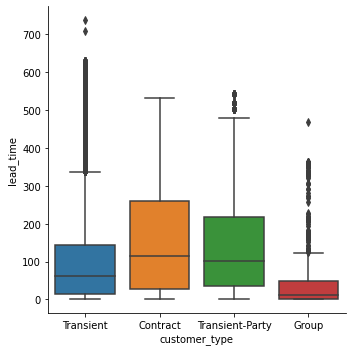

In [ ]:
sns.catplot(data=pandas_df, x='customer_type', y='lead_time', kind='box')

# 19. พล็อตกราฟเส้นแสดงข้อมูลจํานวนผู้เข้าพักรายเดือนแยกสีของเส้นตามโรงแรม (hotel) ใช้ข้อมูลจากข้อ 14 มาพล็อตได้

In [ ]:
plot_df = df.withColumn('year_month_arrival', F.date_format(df.arrival_date, 'yyyy-MM'))\
  .groupby('hotel','year_month_arrival').count()\
  .sort('year_month_arrival', 'hotel').toPandas()

In [ ]:
plot_df

,hotel,year_month_arrival,count
0,City Hotel,2015-07,1398
1,Resort Hotel,2015-07,1378
2,City Hotel,2015-08,2480
3,Resort Hotel,2015-08,1409
4,City Hotel,2015-09,3529
5,Resort Hotel,2015-09,1585
6,City Hotel,2015-10,3386
7,Resort Hotel,2015-10,1571
8,City Hotel,2015-11,1235
9,Resort Hotel,2015-11,1105


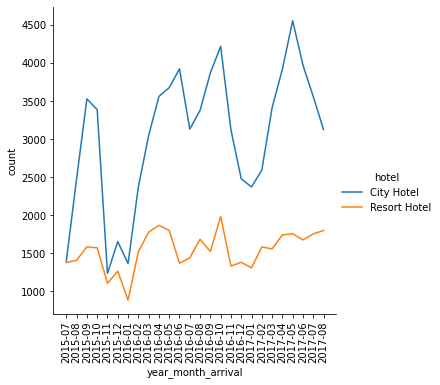

In [ ]:
sns.relplot(data=plot_df, x='year_month_arrival', y='count', hue='hotel', kind='line').set_xticklabels(rotation=90)

# 20. พล็อต histogram แสดงการกระจายตัวของจํานวนผู้เข้าพักในหนึ่งวัน (นํามาจากตารางที่คํานวณในข้อ 13 ได้)

In [ ]:
booking_df = daily_count_df.withColumnRenamed('count', 'daily_customer').toPandas()

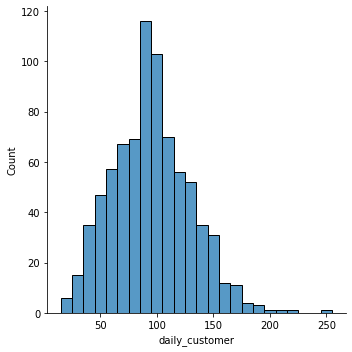

In [ ]:
sns.displot(booking_df['daily_customer'], kind='hist')